In [67]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, activations
from tensorflow .keras.layers import Layer


def stepestrella(x):
    return tf.cast(x > 0, dtype=tf.float32)

class CustomDense(tf.keras.layers.Layer):
    def __init__(self, weights, biases, activations):
        super(CustomDense, self).__init__()
        self.fixed_weights = tf.constant(weights, dtype=tf.float32)
        self.fixed_biases = tf.constant(biases, dtype=tf.float32)
        self.activations = activations  # lista de funciones
    def call(self, inputs):
        z = tf.matmul(inputs, self.fixed_weights)
        z = tf.add(z, self.fixed_biases)
        if isinstance(self.activations, list):
            out = tf.stack([self.activations[i](z[:, i]) for i in range(z.shape[1])], axis=1)
        else:
            out = self.activations(z)
        return out
    
class BaricentricNetworkSegment(Model):
    def __init__(self, a, b, fa, fb, **kwargs):
        super(BaricentricNetworkSegment, self).__init__(**kwargs)
        self.a = a
        self.b = b
        self.fa = fa
        self.fb = fb
        # Layer 1: 4 neurons
        w1 = [[1., -1., 1., -1.]]  # input_dim=1, output_dim=4
        b1 = [0., 0., -1., 1.]
        act1 = [tf.nn.relu, stepestrella, stepestrella, tf.nn.relu]

        self.layer1 = CustomDense(w1, b1, act1)

        # Layer 2: 2 neurons
        w2 = [[-1., 0.], [-2., -2.], [-2., -2.], [0., -1.]]  # 4x2
        b2 = [1.0, 1.0]
        act2 = tf.nn.relu

        self.layer2 = CustomDense(w2, b2, act2)

        # Layer 3: 1 neuron
        w3 = [[self.fa], [self.fb]]  # 2x1
        b3 = [0.]
        act3 = tf.identity

        self.layer3 = CustomDense(w3, b3, act3)

    def call(self, x):
        t = (x - self.a) / (self.b - self.a)
        z = self.layer1(t)
        z = self.layer2(z)
        z = self.layer3(z)
        return z
    
class BaricentricNetwork(Model):
    def __init__(self, points):
        super(BaricentricNetwork, self).__init__()
        self.x_coords = points[:,0]
        self.y_values = points[:,1]
        num_segments = len(self.x_coords) - 1 
        self.subnets = [BaricentricNetworkSegment(a = self.x_coords[i], b = self.x_coords[i+1], fa = self.y_values[i], fb = self.y_values[i+1]) for i in range(num_segments)]
        print(self.subnets)
    def call(self, x):
        outputs = [subnet(x) for subnet in self.subnets]
        return tf.add_n(outputs)

In [76]:
Model = BaricentricNetworkSegment(a=1., b=3., fa=4., fb=2.)

In [77]:
output = Model(tf.constant([[0.99],[1.],[2.],[3.0],[3.01]]))  # Example input to test the model
print(output)  # Should print the shape of the output tensor

tf.Tensor(
[[0.]
 [4.]
 [3.]
 [2.]
 [0.]], shape=(5, 1), dtype=float32)


In [79]:
x_values=tf.expand_dims(tf.linspace(0,7,100),axis=1)
output = Model(x_values)  # Example input to test the model
print(output.shape)  # Should print the shape of the output tensor

(100, 1)


<Figure size 1000x600 with 0 Axes>

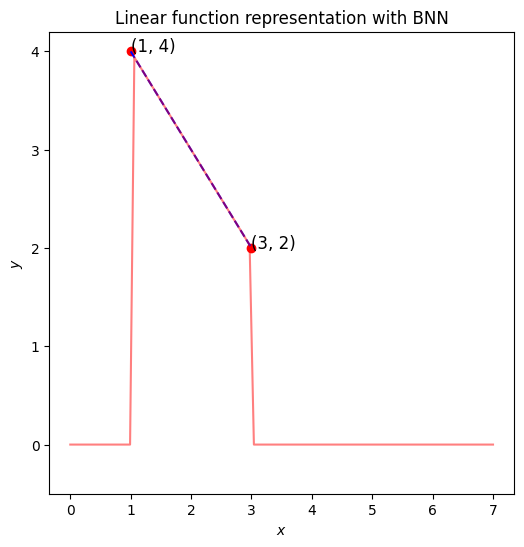

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
x1, y1 = 1, 4
x2, y2 = 3, 2

plt.figure(figsize=(6, 6))
plt.plot([x1, x2], [y1, y2], 'b--', label="Linear function between points")  
plt.scatter([x1, x2], [y1, y2], color='red', label="Points")    

plt.text(x1, y1, f"({x1}, {y1})", fontsize=12)
plt.text(x2, y2, f"({x2}, {y2})", fontsize=12)

plt.plot(x_values, output, 'r-', label='$BNN(x)$',alpha=0.5)
plt.ylim(bottom=-0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Linear function representation with BNN')

plt.show()

In [87]:
points=np.array([[1,2],[3,4],[5,8]],dtype = np.float32)
model = BaricentricNetwork(points)

[<BaricentricNetworkSegment name=baricentric_network_segment_17, built=False>, <BaricentricNetworkSegment name=baricentric_network_segment_18, built=False>]


In [88]:
output = model(tf.constant([[0.99],[1.],[2.],[3.0],[4.],[5.],[5.01]]))  # Example input to test the model
print(output) 

tf.Tensor(
[[0.]
 [2.]
 [3.]
 [8.]
 [6.]
 [8.]
 [0.]], shape=(7, 1), dtype=float32)


(100, 1)


<Figure size 1000x600 with 0 Axes>

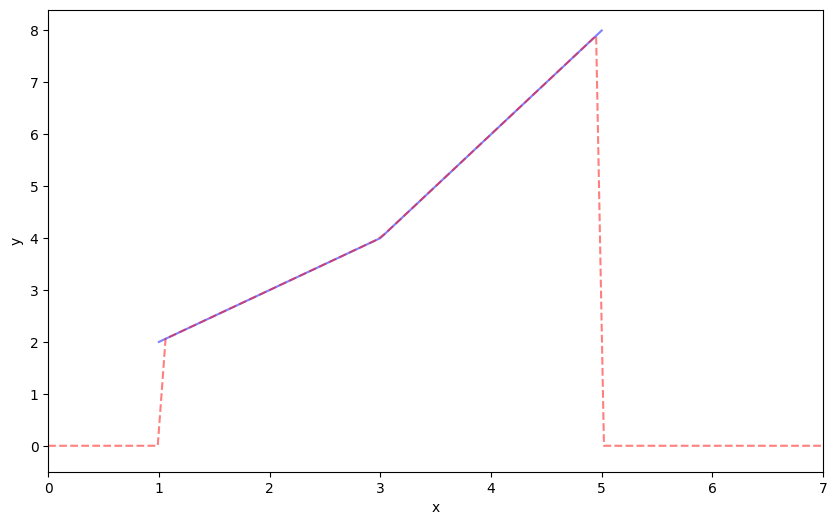

In [90]:
x_values=tf.expand_dims(tf.linspace(0,7,100),axis=1)
output = model(x_values)  # Example input to test the model
print(output.shape) 

plt.figure(figsize=(10, 6))
xs = [point[0] for point in points]
ys = [point[1] for point in points]

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'b-', label="f(x)", alpha=0.5)
plt.plot(x_values, output, 'r--', label='$BNN(x)$', alpha=0.5)
plt.xlim((0,7))
plt.ylim(bottom=-0.5)
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('figures/BNNRepresentationCPLFExample1Tf.png', dpi=300, bbox_inches='tight')
plt.show()